# ONLY RUN THE NEXT CELL ONCE!

In [ ]:

from weis_workshop import *

if IN_COLAB:
    !pip install -q condacolab
    import condacolab
    condacolab.install() # expect a kernel restart
    from google.colab import drive
    drive.mount('/content/drive')
    !git clone -b weis-workshop  https://github.com/wisdem/weis
    !mamba env update -n base -f weis/environment.yml
    !mamba install -y petsc4py=3.22.2 mpi4py pyoptsparse
    %cd weis
    !pip install .
    %cd ..
    !git clone https://github.com/mayankchetan/weisWorkshop-Private

else:
    try:
        import weis
    except ImportError:
        raise ImportError("Please install the weis package from https://github.com/wisdem/weis in the environment you are using to run this notebook.")

    Warning("Make sure you have cloned 'https://github.com/mayankchetan/weisWorkshop-Private' repository and are running the notebook from the root directory of the repository.")





Running in local environment


pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.DeprecationWarning: /kfs2/projects/weis/mchetan/weis-workshop/env/weis-workshop-script1/lib/python3.12/site-packages/pkg_resources/__init__.py:3146
Deprecated call to `pkg_resources.declare_namespace('sphinxcontrib')`.
Implementing implicit namespace packages (as specified in PEP 420) is preferred to `pkg_resources.declare_namespace`. See https://setuptools.pypa.io/en/latest/references/keywords.html#keyword-namespace-packages

Using weis.aeroelasticse in rosco.toolbox...


Accessing Draft4Validator.resolver is deprecated as of v4.18.0, in favor of the https://github.com/python-jsonschema/referencing library, which provides more compliant referencing behavior as well as more flexible APIs for customization.PendingDeprecationWarning: /kfs2/projects/weis/mchetan/weis-workshop/tools/weis/weis/dtqpy/classes/DTQPy_CLASS_INTERNAL.py:10
Importing from numpy.matlib is deprecated since 1.19.0. The matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray. 

# Introduction
 > Write some info

# Objectives
You are assigned to design and optimize a 20MW Floating wind turbine with the following constriants.
1. test
2. test
3. test

# The Approach 
1. Start with the IEA 22MW folating turbine. Establish a baseline 
2. Modify the rotor, try aero, structural and aero + structural optimization
3. Optimize the controller to the updated rotor
4. Optimize the substructure uisng RAFT
5. Continue optimization using OpenFAST & OpenFAST+Controller
6. Conduct a full DLC analysis

In [ ]:
# Importing nesscary libraries.
import numpy as np
import matplotlib.pyplot as plt
from weis import weis_main
from wisdem import run_wisdem
import os
import copy
import pandas as pd

# workshop repository folder
if IN_COLAB:
    WORKSHOP_REPO = '/content/weisWorkshop-Private'
else:
    WORKSHOP_REPO = os.path.join(os.getcwd(), '..')

## Stage 0: Establishing a baseline

We begin with establishing a baseline using an exisitng wind turbine model. Since we are desgining an 20MW model, lets start with the IEA 22MW turbine. 

In [3]:
# Setting up file paths
stageFolder = "stage-0-baseline"

fname_wt_input = os.path.join(WORKSHOP_REPO, "source", "IEA-22-280-RWT_Floater.yaml")
fname_modeling_options = os.path.join(WORKSHOP_REPO, stageFolder, "stage-0-baseline_modeling.yaml")
fname_analysis_options = os.path.join(WORKSHOP_REPO, stageFolder, "stage-0-baseline_analysis.yaml")


## Lets Open the input files and take a Look at them.
### Google Colab Users:
1. Go to the file browser on the left
2. Navigate to the cloned repository
3. Open the YAML files to examine the configuration

## Turibne geometry file
This file defines the trubine using the WindIO format. Currently we are using the v2.0 of WindIO. Lets take a look at the high level parts of the file.

```yaml
name: IEA 22MW Offshore Wind Turbine in Floating Configuration
assembly:
    turbine_class: I
    turbulence_class: B
    drivetrain: direct_drive
    rotor_orientation: Upwind
    number_of_blades: 3
    hub_height: 170.0
    rotor_diameter: 284.0
    rated_power: 22000000.0
    lifetime: 25.0
components:
  blade:
    outer_shape_bem:
      reference_axis:
        x: { grid: [...], values: [...] }
        y: { grid: [...], values: [...] }
        z: { grid: [...], values: [...] }
      chord: { grid: [...], values: [...] }
      twist: { grid: [...], values: [...] }
    internal_structure_2d_fem:
      reference_axis: [...]
      layers: [...]
      webs: [...]
  hub:
    diameter: 7.94  # m
    cone_angle: -2.5  # degrees
    
  nacelle:
    drivetrain: [...]
    transformer: [...]
    
  tower:
    outer_shape_bem: [...]
    internal_structure_2d_fem: [...]
    
  mooring:
    nodes: [...]
    lines: [...]
airfoils: [...]
materials: [...]
controls: [...]
environment: [...]
bos: [...]
costs: [...]
```


## analysis and modeling options
These files define the analysis and modeling options for the WISDEM/WEIS

### Analysis options
```yaml
general:
    folder_output: outputs/
    fname_output: stage-0-baseline
```
### Modeling options
```yaml
General:
    verbosity: False

WISDEM:
    RotorSE:
        flag: True
    TowerSE:
        flag: True
    DriveSE:
        flag: True
    FloatingSE:
        flag: True
    BOS:
        flag: True

OpenFAST: # Options for WEIS fidelity level 3 = nonlinear time domain
    flag: False

RAFT:
    flag: False

ROSCO:
    flag: True
    tuning_yaml: ../source/iea22_rosco.yaml
```


In [4]:
# lets overide a few things so that we dont distrupt the existing results.
analysis_override = {}
analysis_override['general'] = {}
analysis_override['general']['folder_output'] = 'outputsCh1'


iea22mw, modeling_options, opt_options = weis_main(fname_wt_input, 
                                                 fname_modeling_options, 
                                                 fname_analysis_options,
                                                 analysis_override=analysis_override,
                                                 test_run=False
                                                 )

Accessing Draft4Validator.resolver is deprecated as of v4.18.0, in favor of the https://github.com/python-jsonschema/referencing library, which provides more compliant referencing behavior as well as more flexible APIs for customization.

integrate total mass density:  1574044.8711078241

wisdem.wt.wt_rna


NL: NLBGS 1 ; 5.83474702e+11 1


NL: NLBGS 2 ; 45999270.8 7.8836787e-05


NL: NLBGS 3 ; 7036.00667 1.20588033e-08


NL: NLBGS 4 ; 29.0120856 4.97229538e-11
NL: NLBGS Converged


Skipping duplicate mode.


ORBIT library intialized at '/kfs2/projects/weis/mchetan/weis-workshop/env/weis-workshop-script1/lib/python3.12/site-packages/library'
Cp-Ct-Cq surfaces completed at 5 %
Cp-Ct-Cq surfaces completed at 10 %
Cp-Ct-Cq surfaces completed at 15 %
Cp-Ct-Cq surfaces completed at 20 %
Cp-Ct-Cq surfaces completed at 25 %
Cp-Ct-Cq surfaces completed at 30 %
Cp-Ct-Cq surfaces completed at 35 %
Cp-Ct-Cq surfaces completed at 40 %
Cp-Ct-Cq surfaces completed at 45 %
Cp-Ct-Cq surfaces completed at 50 %
Cp-Ct-Cq surfaces completed at 55 %
Cp-Ct-Cq surfaces completed at 60 %
Cp-Ct-Cq surfaces completed at 65 %
Cp-Ct-Cq surfaces completed at 70 %
Cp-Ct-Cq surfaces completed at 75 %
Cp-Ct-Cq surfaces completed at 80 %
Cp-Ct-Cq surfaces completed at 85 %
Cp-Ct-Cq surfaces completed at 90 %
Cp-Ct-Cq surfaces completed at 95 %
Cp-Ct-Cq surfaces completed at 100 %
-----------------------------------------------------------------------------
   Tuning a reference wind turbine controller using NREL's ROSCO to

Accessing Draft4Validator.resolver is deprecated as of v4.18.0, in favor of the https://github.com/python-jsonschema/referencing library, which provides more compliant referencing behavior as well as more flexible APIs for customization.

----------------
Design Variables
----------------
name  val  size  lower  upper  
----  ---  ----  -----  ----- 

-----------
Constraints
-----------
name  val  size  lower  upper  equals  
----  ---  ----  -----  -----  ------ 

----------
Objectives
----------
name  val  size  
----  ---  ---- 

Run time (outputsCh1): 25.163851737976074


In [5]:
# Lets analyize the baseline design!!
baseline_turb = pd.read_csv(os.path.join(WORKSHOP_REPO, stageFolder, "outputsCh1/stage-0-baseline.csv"), index_col=0)
# Open the CSV file shown above so explore the various variables output from WISDEM/WEIS

print(f'there are {len(baseline_turb.index)} variables in the baseline design:')

baseline_turb.index 

there are 4754 variables in the baseline design:


Index(['sse_tune.v_min', 'sse_tune.v_max', 'sse_tune.r', 'sse_tune.chord',
       'sse_tune.theta', 'sse_tune.Rhub', 'sse_tune.Rtip',
       'sse_tune.hub_height', 'sse_tune.precone', 'sse_tune.tilt',
       ...
       'rotorse.rs.tot_loads_gust.Pz_af',
       'rotorse.stall_check.no_stall_constraint',
       'rotorse.stall_check.stall_angle_along_span', 'xf.span_start',
       'xf.cl_interp_flaps', 'xf.cd_interp_flaps', 'xf.cm_interp_flaps',
       'xf.flap_angles', 'xf.Re_loc', 'xf.Ma_loc'],
      dtype='object', name='variables', length=4754)

As you can see from the listing the variables in the CSV files, WEIS outputs a lot of information about the wind turbine model/run.

Lets look at a few of them to help us understand the baseline design.
- rotorse.rp.powercurve.V --> Wind speed (m/s)
- rotorse.rp.powercurve.Cp_aero --> Power Coefficient
- rotorse.rp.powercurve.Ct_aero --> Thrust Coefficient
- rotorse.rp.powercurve.P --> Power (W)
- rotorse.rp.powercurve.T --> Thrust (N)
- rotorse.rp.powercurve.pitch --> Pitch Angle (deg)

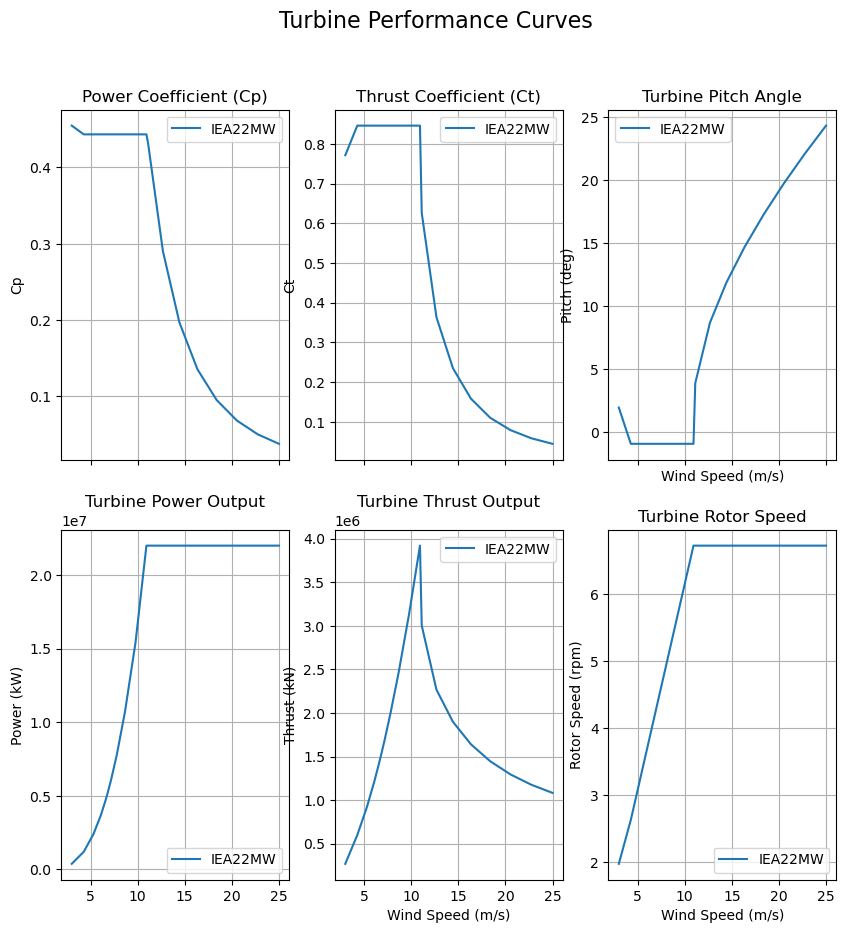

In [6]:
plot_comparison_plot(baseline_turb, label='IEA22MW')

## This looks good! or does it?
- At a first glance the power curve looks good. But something seems off. Any guesses?
- Cp for the IEA 22MW is ~0.49, but the plot above shows a Cp of ~0.45. Why is that?
- The IEA 22MW turbine is higly flexible and is torsionally compilant. The performace above uses CCBlade in the back end that does not account for blade flexibility. To be able to capture the correct performance we need to use a higher fidelity blade model like BeamDyn in OpenFAST. But for a an initial design and optimization pass like we are doing today, this is a good start.



## Converting the IEA 22MW to a 20MW
- We start by modifying the IEA 22MW turbine input geometry file.
- To start, we can take the equation for power of a rotor.

 $P = \frac{1}{2} \rho A V^3 C_p$

- We can assume, $\rho$ $V$ and $C_p$ to be constant. So for a 20MW turbine, we have

 $D_{20MW} = \sqrt{ 284.0^2 * \frac{20}{22}}  = 270.0$

 - Now we make a copy of the IEA 22MW turbine geometry file and modify the rotor diameter and power rating.

``` yaml
assembly:
    turbine_class: I
    turbulence_class: B
    drivetrain: direct_drive
    rotor_orientation: Upwind
    number_of_blades: 3
    hub_height: 170.0
    rotor_diameter: 270.0 # 284.0
    rated_power: 20000000.0 # 22000000.0
    lifetime: 25.0
```


# Optimizing the rotor!

Now that we have a baseline design, and the new 20MW geometry file, we can start optimizing the rotor. 

To have a simplified approach, we can use WISDEM to optimize the rotor, instead of using a more complex approach using OpenFAST+Controller. This approach will give us first pass quick and dirty optimization. This is also how we use multiple tools in the optimization process in a systematic way, and not setup a single large complex optimization problem that might be hard to solve.

In [7]:
# Setting up file paths, and defining the WEIS overide for this stage
stageFolder = "stage-1-aeroStruct"

fname_wt_input = os.path.join(WORKSHOP_REPO, "source", "new-20-270-RWT_Floater.yaml")
fname_modeling_options = os.path.join(WORKSHOP_REPO, stageFolder, "stage-1-aeroStruct-aero_analysis.yaml")
fname_analysis_options = os.path.join(WORKSHOP_REPO, stageFolder, "stage-1-aeroStruct-aero_modeling.yaml")

# We dont have analysis, and modeling options overrides in WISDEM
# analysis_override = {}
# analysis_override['general'] = {}
# analysis_override['general']['folder_output'] = 'outputsCh1'
# analysis_override['driver'] = {}
# analysis_override['driver']['max_iter'] = 1 # only run one iteration for this demo, we have precomputed the solutions for you :)

## Lets Open the input files and take a Look at them.
### Google Colab Users:
1. Go to the file browser on the left
2. Navigate to the cloned repository
3. Open the YAML files to examine the configuration

## Analysis options:
```yaml

design_variables:
 
    blade:
        aero_shape:
            twist:
                flag: False # Flag to optimize the twist
                inverse: True # Flag to determine twist from a desired angle of attack
                inverse_target: 'max_efficiency' # Twist generates angles of attack # corresponding to 'max_efficiency' or 'stall_margin'
                n_opt: 10 # Number of control points along blade span. During inverse design, # twist is smoothened with a spline with these
                max_decrease: 0.08722222222222221 # Maximum decrease for the twist in [rad] at the n_opt locations. Only used if flag is set to True
                max_increase: 0.08722222222222221 # Maximum increase for the twist in [rad] at the n_opt locations. Only used if flag is set to True
                index_start: 2 # Lock the first two DVs from blade root
                index_end: 10 # All DVs close to blade tip are active

            chord:
                flag: True # Flag to optimize the chord
                n_opt: 10 # Number of control points along blade span
                max_decrease: 0.4 # Minimum multiplicative gain on existing chord at the n_opt locations
                max_increase: 1.5 # Maximum multiplicative gain on existing chord at the n_opt locations
                index_start: 1 # Lock the first DV from blade root
                index_end: 9 # All DVs close to blade tip are active
            af_positions:
                flag: True
                af_start: 4
        structure:
            - layer_name: spar_cap_ss
              n_opt: 8               # Number of control points along blade span
              max_decrease: 0.2      # Maximum nondimensional decrease at the n_opt locations
              max_increase: 5.       # Maximum nondimensional increase at the n_opt locations
              index_start: 1         # Lock the first DV from blade root
              index_end: 7           # The last DV at blade tip is locked
            - layer_name: spar_cap_ps
              n_opt: 8               # Number of control points along blade span
              max_decrease: 0.2      # Maximum nondimensional decrease at the n_opt locations
              max_increase: 5.       # Maximum nondimensional increase at the n_opt locations
              index_start: 1         # Lock the first DV from blade root
              index_end: 7           # The last DV at blade tip is locked
            - layer_name: te_reinforcement_ss
              n_opt: 8               # Number of control points along blade span
              max_decrease: 0.2      # Maximum nondimensional decrease at the n_opt locations
              max_increase: 5.       # Maximum nondimensional increase at the n_opt locations
              index_start: 1         # Lock the first DV from blade root
              index_end: 7           # The last DV at blade tip is locked
            - layer_name: te_reinforcement_ps
              n_opt: 8               # Number of control points along blade span
              max_decrease: 0.2      # Maximum nondimensional decrease at the n_opt locations
              max_increase: 5.       # Maximum nondimensional increase at the n_opt locations
              index_start: 1         # Lock the first DV from blade root
              index_end: 7           # The last DV at blade tip is locked

# figure of merit
merit_figure: LCOE

constraints:
    blade:
        stall:
            flag: False # Constraint on minimum stall margin
            margin: 0.12 # Value of minimum stall margin in [rad]
        chord:
            flag: True # Constraint max chord to its default value (4.75 m)
            max: 8. # Max chord value
        chord_slope:
            flag: True # Constraint to enforce monothonically decreasing chord after max chord
        root_circle_diameter:
            flag: False # Constraint for the minimum blade root circle diameter
            max_ratio: 1.2 # The recommended value can be up to 20% larger than the actual
        moment_coefficient:
            flag: False # Constraint on maximum blade root flapwise moment coefficient
            max: 0.20 # Lowering this value will lead to low induction rotors
        strains_spar_cap_ss:
            flag: True         # Flag to impose constraints on maximum strains (absolute value) in the spar cap on the blade suction side
            max:    3500.e-6   # Value of maximum strains [-]
            index_start: 1     # Do not enforce constraint at the first station from blade root of the n_opt from spar_cap_ss
            index_end: 7       # Do not enforce constraint at the last station at blade tip of the n_opt from spar_cap_ss
        strains_spar_cap_ps:
            flag: True         # Flag to impose constraints on maximum strains (absolute value) in the spar cap on the blade pressure side
            max:    3500.e-6   # Value of maximum strains [-]
            index_start: 1     # Do not enforce constraint at the first station from blade root of the n_opt from spar_cap_ps
            index_end: 7       # Do not enforce constraint at the last station at blade tip of the n_opt from spar_cap_ps      
        tip_deflection:
            flag: True
            margin: 1.4175

driver:
    optimization:
        flag: True          # Flag to enable optimization
        tol: 1.e-6          # Optimality tolerance
        max_iter: 1000      # Maximum number of iterations (SLSQP)
        solver: SLSQP       # Optimization solver. Other options are 'SLSQP' - 'CONMIN'
        step_size: 1.e-3    # Step size for finite differencing
        form: central       # Finite differencing mode, either forward or central

recorder:
    flag: True              # Flag to activate OpenMDAO recorder
    file_name: log_opt.sql  # Name of OpenMDAO recorder


```

## Modeling Options:

```yaml
General:
    verbosity: True  # When set to True, the code prints to screen many infos


WISDEM:
    RotorSE:
        flag: True
        spar_cap_ss: spar_cap_ss
        spar_cap_ps: spar_cap_ps

    DriveSE:
        flag: False
    TowerSE:
        flag: True
    FloatingSE:
        flag: False
    BOS:
        flag: False

```


# Before running the next cell, make sure you have done the following:
1. Update the analysis option output path to `outputsCh1`
2. Update the max_iter to 1 --> only run one iteration for this demo, we have precomputed the solutions for you :)

In [8]:
# input("Have you updated the analysis options file? Press Enter to continue...")

wt_opt, modeling_options, analysis_options = run_wisdem(
        fname_wt_input, fname_modeling_options, fname_analysis_options
    )


WISDEM run completed in, 4.447252035140991 seconds


## Now lets analyze the results!

1. We have run the optimization for you! The results are stored in the `outputs` folder. Lets load the results and plot them.
2. Additionally, we ran the case without any optimization to compare the 'before and after' of the optimization.

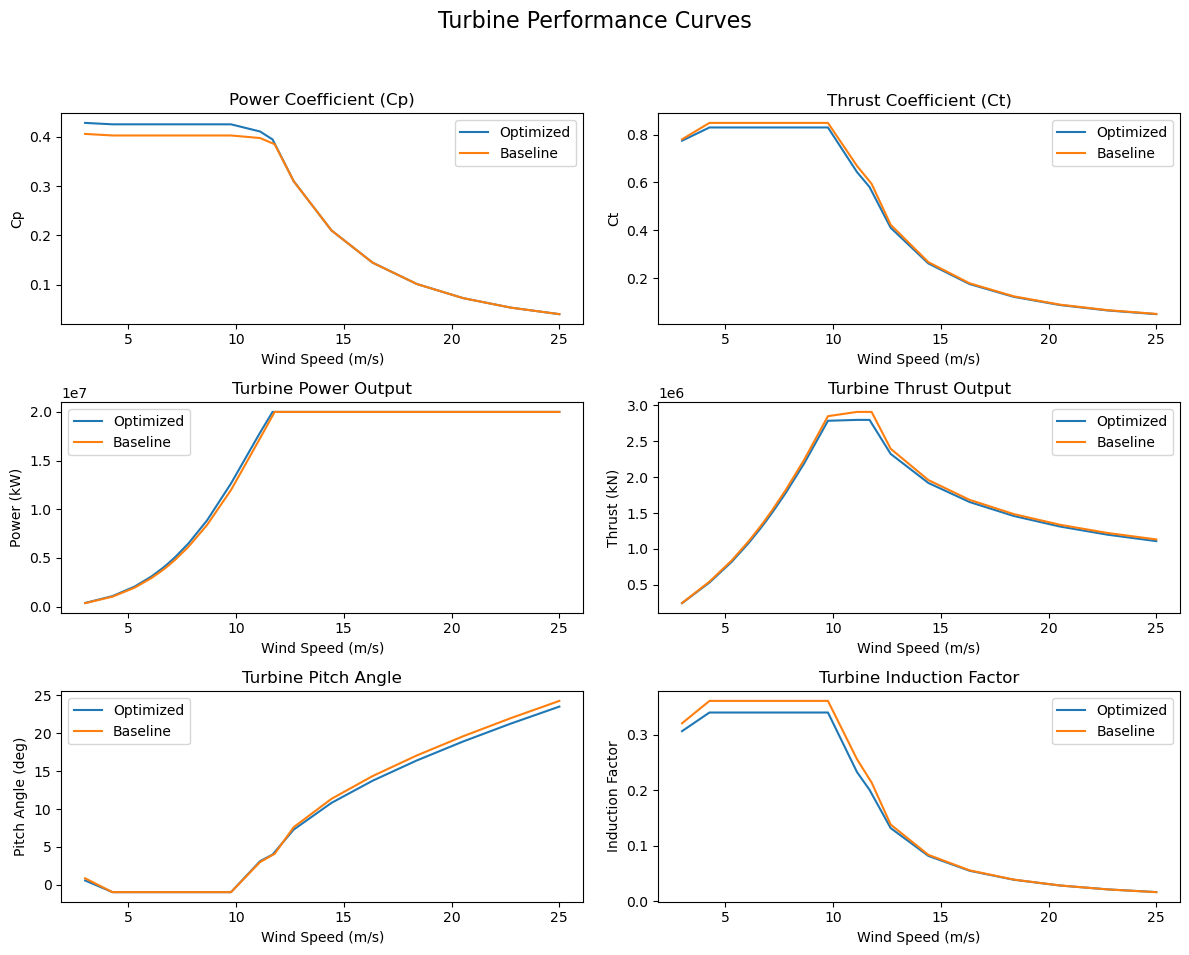

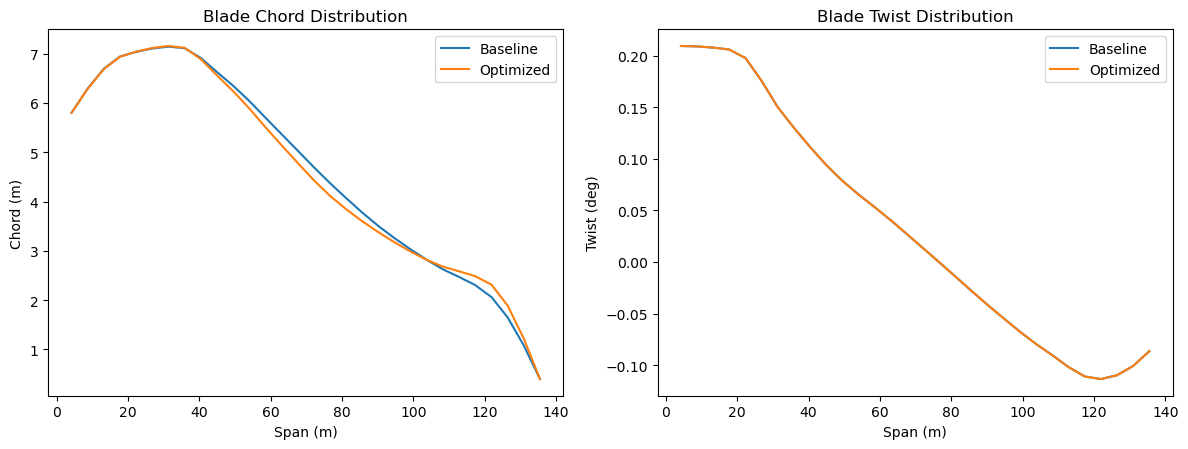

In [9]:
baseline_turb = pd.read_csv(os.path.join(WORKSHOP_REPO, stageFolder,"outputs_nonOpti/stage-1-aeroStruct-NonOptimized.csv"), index_col=0)
optimized_turb = pd.read_csv(os.path.join(WORKSHOP_REPO, stageFolder,"outputs_preCompute/stage-1-aeroStruct-aero_analysis.csv"), index_col=0)

plot_rotor_comparison(baseline_turb, optimized_turb)

## Lets talk about caveats!
- As discussed earlier, the optimization is done using CCBlade in the back end. So the performance numbers are not exact. But the trends are correct.
- If you'd like to capture a more accurate performance, you'll need to use WEIS with OpenFAST+BeamDyn, which can be very computationally expensive.

## Hows the convergance of the optimization?
- The optimization converged in 44 iterations.
- We can use the log_opt.sql that logs the optimization history to plot the convergance.

loading /projects/weis/mchetan/weis-workshop/workshopFiles/stage-1-aeroStruct/outputs_preCompute/log_opt.sql


driver
rank0:ScipyOptimize_SLSQP|0
rank0:ScipyOptimize_SLSQP|1
rank0:ScipyOptimize_SLSQP|2
rank0:ScipyOptimize_SLSQP|3
rank0:ScipyOptimize_SLSQP|4
rank0:ScipyOptimize_SLSQP|5
rank0:ScipyOptimize_SLSQP|6
rank0:ScipyOptimize_SLSQP|7
rank0:ScipyOptimize_SLSQP|8
rank0:ScipyOptimize_SLSQP|9


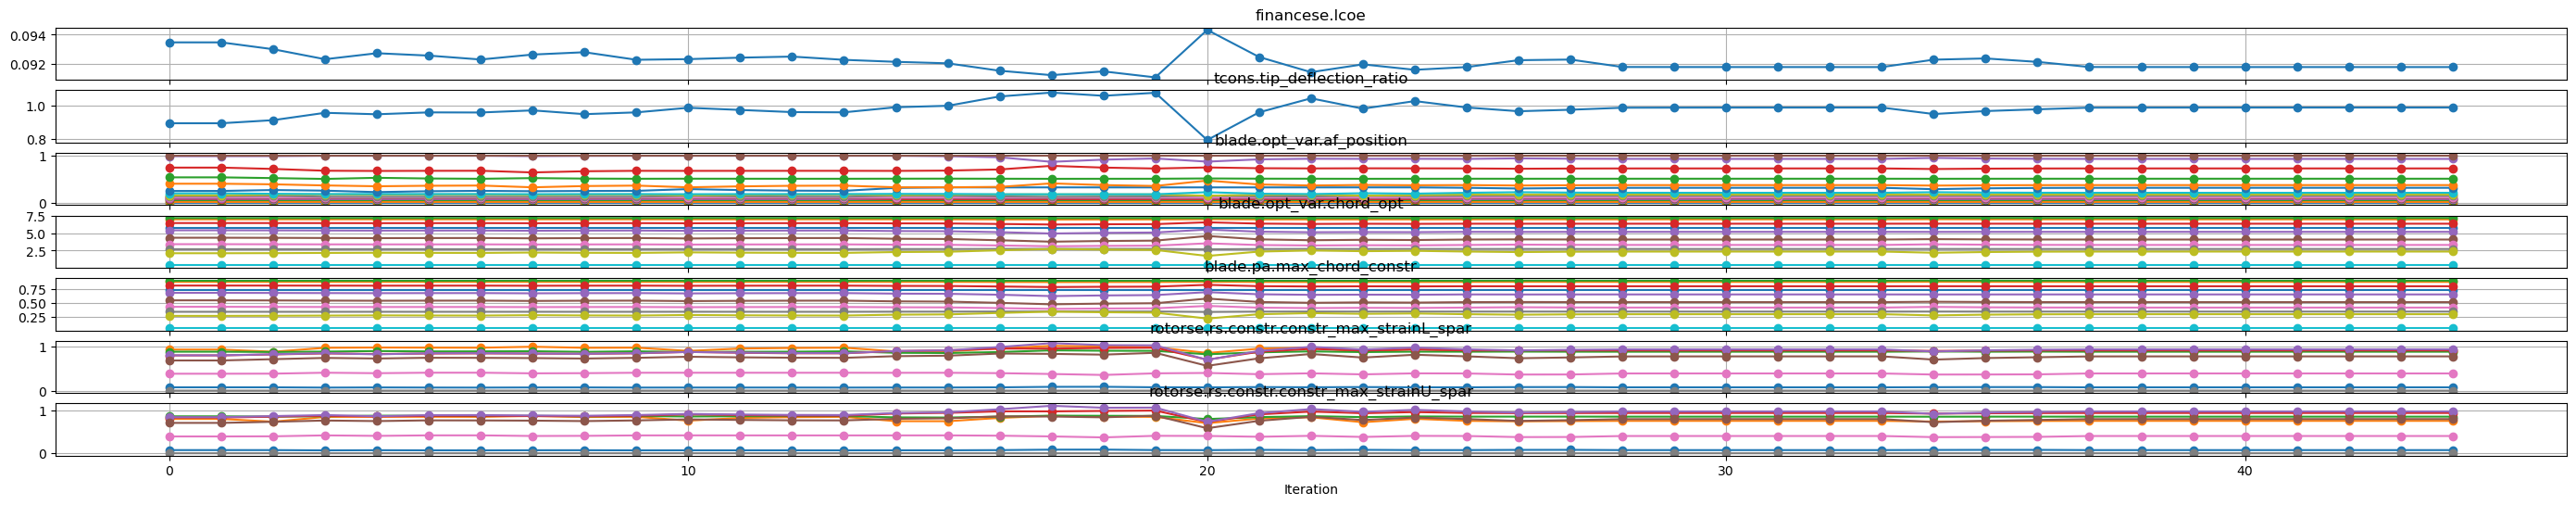

In [10]:
rec_data = load_OMsql(os.path.join(WORKSHOP_REPO, stageFolder,"outputs_preCompute/log_opt.sql")) # not sure what supresses the output here
plot_convergence(rec_data, ['financese.lcoe', 'tcons.tip_deflection_ratio', 'blade.opt_var.af_position', 'blade.opt_var.chord_opt', 'blade.pa.max_chord_constr',
                            'rotorse.rs.constr.constr_max_strainL_spar', 'rotorse.rs.constr.constr_max_strainU_spar'])

# We have a new rotor!!

## Things we accomplished in this session!
- We started with an existing turbine model, the IEA 22MW floating wind turbine and established a baseline
- An overview of the WEIS/WISDEM input files and their structure
- We ran the IEA 22MW turbine to establish a baseline, and plotted the results from the CSV file
- We modified the IEA 22MW turbine to a 20MW turbine by changing the rotor diameter and rated power
- We optimized the rotor using WISDEM
- We inspected the optimization log using the log_opt.sql file, and plotted the convergence
- We compared the unoptimized and optimized 20MW rotors.